# Example: Structured latent confounders

## Outline

- [Setup](#setup)
- [Overview: Observational Causal Inference with Grouped Data](#overview:-observational-causal-inference-with-grouped-data)
    - [Task: Treatment effect estimation with observational data](#task:-treatment-effect-estimation-with-observational-data)
    - [Challenge: Confounding](#challenge:-confounding)
    - [Assumptions: All latent confounders shared within an object](#assumptions:-all-latent-confounders-shared-within-an-object)
    - [Intuition: Statistically adjusting for confounding](#intuition:-statistically-adjusting-for-confounding)
- [Example: Electric Company Education Study](#example:-electric-company-education-study)
    - [Variables](#variables)
    - [Motivation](#motivation)
    - [Source](#source)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Prior Description](#prior-description)
    - [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)
- [Causal Query: average treatment effect (ATE)](#causal-query:-average-treatment-effect-\(ATE\))
- [Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)
    - [Gaussian Mean Field Variational Inference](#gaussian-mean-field-variational-inference)
- [Results](#results)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%reload_ext autoreload
%pdb off

import torch
import pyro
import torch.nn as nn
import pyro.distributions as dist
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt

from torch import Tensor

from pyro.nn import PyroModule, PyroParam, PyroSample

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

Automatic pdb calling has been turned OFF


## Overview: Observational Causal Inference with Grouped Data


In other examples, we have demonstrated how probabilistic programs can be used to model causal relationships between attributes of individual entities. However, it is often useful to model relationships between multiple kinds of entities explicitly.

For example, a student's educational outcome may depend on her own attributes, as well as the attributes of her school. In this hierarchical setting, where multiple students belong to the same school, we can often estimate causal effectseven if these potentially confounding school-level attributes are latent.

Hierarchical structure is a common motif in social science and econometric applications of causal inference; appearing in multi-level-models \[Gelman et al. 2006\], difference-in-difference designs \[Shadish et al. 2002\], and within-subjects designs \[Loftus and Masson 1994\], all of which are out of scope for graph-based identification and adjustment methods. Nonetheless, even flexible Gaussian process versions of these kinds of causal designs can be implemented in a causal probabilistic programming language \[Witty et al. 2021\].

### **Task:** Treatment effect estimation with observational data
Just as in the [backdoor](backdoor.ipynb) example, in this example we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X = \{X_1, ..., X_d\}$. 

Unlike the [backdoor](backdoor.ipynb) example however, here our data is partitioned into a collection of distinct groups which we'll call "objects". In addition to measurements of $T$, $Y$, and $X$, we also know which instances (e.g. students) belong to which object (e.g. school).

Again, we'll assume that $T$ is a binary random variable, but the concepts carry over exactly when $T$ is continuous or discrete-ordinal.

### **Challenge:** Confounding

As the task here is exactly identical to the [backdoor](backdoor.ipynb) example, so too are the challenges. From that example:

"Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$. In these kinds of *observational* settings, some collection of variables $Z = \{Z_1, ..., Z_{d'}\}$ may influence both $T$ and $Y$, resulting in a statistical dependence that is not reflective of the causal effect we are interested in estimating. These variables are called "confounders", and pose a serious problem for drawing causal conclusions from observational data."

**Note:** While the challenges remain the same between these two examples, the assumptions we make will differ substantially.

### **Assumptions:** All latent confounders shared within an object

In this example we assume that all confounders between $T$ and $Y$ are observed, as in the [backdoor](backdoor.ipynb) example, or are shared between individual units belonging to the same object. For example, this assumptions allows for the possibility that attributes like "school funding" confound the relationship between students' treatment and outcome variables, as any student who attends the same school is subject to the effects of the same level of funding. However, here we are still assuming that any student-level attributes like "family income" are either (i) observed or (ii) are not confounders. 

### **Intuition:** Statistically adjusting for confounding

In the [backdoor](backdoor.ipynb) example we developed an intuition for how we might be able to statistically adjust for confounding by finding groups of individuals with similar or identical values of all observed confounders. Unfortunately, not all confounders are observed in this settings. However, because of our assumption about latent confounders being shared within an object, grouping individuals according to their observed covariates **and** the objects they belong to ensures that every individual within each subgroup still contains similar or identical values for all confounders, and thus remaining statistical dependence must be attributable to $T$'s effect on $Y$.

Again, this "matching" description provides an intuition, but the actual algorithmic process does not construct these subgroups explicitly. Instead, we'll explicitly represent proxies for latent confounders in a hierarchically structured probabilsitic program, and jointly perform inference over these proxy latent confounders and counterfactual outcomes. This implicitly produces a Bayesian variant of partial pooling in which some information is shared between groups while retaining the validity of the causal inferences.

## Example: Electric Company Education Study

**Note:** Earlier we discussed the problem of causal inference with hierarchically structured observational data. In this example we analyze an experimental setup in which treatment assignment probability depends on the school and grade. As we don't have access to the study design explicitly, this setup exhibits nearly identical challenges to the observational setting. The randomized treatment assignment depends on variables that also influence educational outcomes.

### Variables

As a working example, consider the scenario where $T$ represents whether a class was ($T=1$) or was not ($T=0$) shown a television program called "The Electric Company" as a part of their grade-school education, and $Y$ represents their reading comprehension test scores at the end of the study. In addition to these measurements, we also gather a collection of covariates $X$ describing the classes' pre-exposure test scores and whether they were in elementary school grades 1, 2, 3, or 4. Finally, we record which school each class beloned to.

### Motivation

Understanding the effect of the education program may be useful for education policymakers who may wish to provide additional funding for similar programs in the future. In addition, curriculum designers could use these study results to better align classroom activity with educational outcome goals. Both of these use-cases require causal insight, as changes to policy or curriculum are best thought of as an intervention. See our [Introductory Tutorial](tutorial_1.ipynb) for a more in-depth discussion of the difference between association and intervention.

### Source

This scenario (and the data we'll use later) come from a real study by Samuel Ball on the efficacy of television programs as a reading supplement \[Ball 1973\].

In [2]:
# Load the data
DATA_URL = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
df = pd.read_csv(DATA_URL, delimiter=",", index_col=0)

# See Chapter 23 in http://ecologia.ib.usp.br/curso_r/lib/exe/fetch.php/bie5782:00_curso_avancado:uriarte:gelman_hill2007_data_analysis_using_regression_and_multilevel-hierarchical_models.pdf

# Drop the description of whether the intervention was used as a supplement to teaching or as a replacement for teaching, as it is post-treatment and
# may introduce collider bias.
df = df.drop("supp", axis=1)


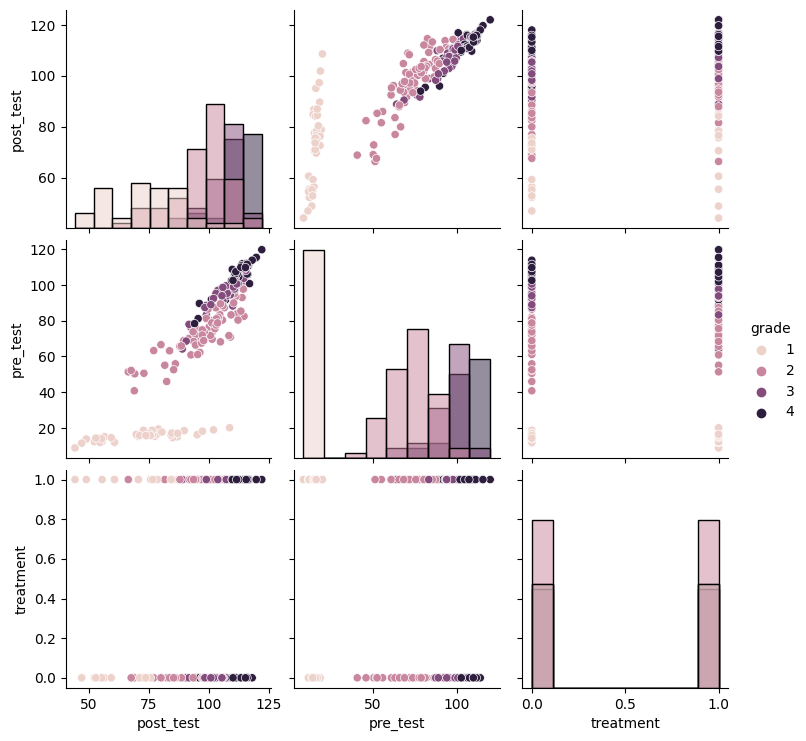

In [3]:
sns.pairplot(df.drop("pair_id", axis=1), hue="grade", diag_kind="hist")

In [4]:
# Prepare data for SLC models below.
treated_df = df[df["treatment"] == 1]
control_df = df[df["treatment"] == 0]

d_X = 5
n_instances = 2
n_objects = 96

# Process covariates with one-hot encoding of categorical "grade" covariate
X_obs = np.ones((n_instances, n_objects, d_X))
X_obs[0, :, 0]  = control_df["pre_test"].values
X_obs[0, :, 1:] = pd.get_dummies(control_df["grade"]).values
X_obs[1, :, 0]  = treated_df["pre_test"].values
X_obs[1, :, 1:] = pd.get_dummies(treated_df["grade"]).values

T_obs = np.ones((n_instances, n_objects))
T_obs[0, :] = 0.

Y_obs = np.ones((n_instances, n_objects))
Y_obs[0, :] = control_df["post_test"].values
Y_obs[1, :] = treated_df["post_test"].values

X_obs = torch.tensor(X_obs).float()
T_obs = torch.tensor(T_obs).float()
Y_obs = torch.tensor(Y_obs).float()

## Causal Probabilistic Program

Our causal assumptions can be encoded as a probabilistic program in Pyro. Here, unlike in the [Tutorial](tutorial_i.ipynb), we'll write a probabilistic program in a single pass that includes the causal relationships between attributes and the priors over parameters.

### Model Description

In our qualitative description of assumptions previously we discussed how latent confounders are shared across all instances belonging to the same object. In this setting that means that all classes within the same school (as indicated by the pair id) are subject to the school-level attributes. We can represent this in our causal probabilsitic program using a simple nested plate structure.

As many of the assumptions for the SLC model are exactly the same as the [backdoor](backdoor.ipynb) model, it shouldn't be surprising that the two probabilistic programs share many of the same characteristics. In fact given a fixed value of the object-level proxy latext confounder `U`, for all of the attributes at the unit-level (elementary school courses in our example) the causal assumptions can be again codified entirely in the ordering of random variables in our causal probabilstic program. In particular, our causal probabilsitic program first samples `X` from a multivariate Gaussian, then samples `T` from a Bernoulli distribution with a weight parameter dependent on `X`, and finally samples `Y` from Normal distribution dependent on `X` and `T`.

Moving beyond simple linear models, recent work has introduced *Gaussian Processes with Structured Latent Confounders* (GP-SLC) \[Witty et al. 2020\], using flexible Gaussian process priors for causal inference in hierarchical settings. To emphasize that this hierarchical structure is quite general, we first write a probabilistic program in which the structural functions are yet-unspecified, and then instantiate it with linear functions to match this example scenario. The following generative program is a slightly simplified variant of GP-SLC.

### Prior Description

In order to represent our uncertainty over causal models, we place `Normal` priors on each of linear weight and bias parameters, and `HalfCauchy` priors on the noise variance parameters. These were chosen based on the desired suport of the respective parameters.

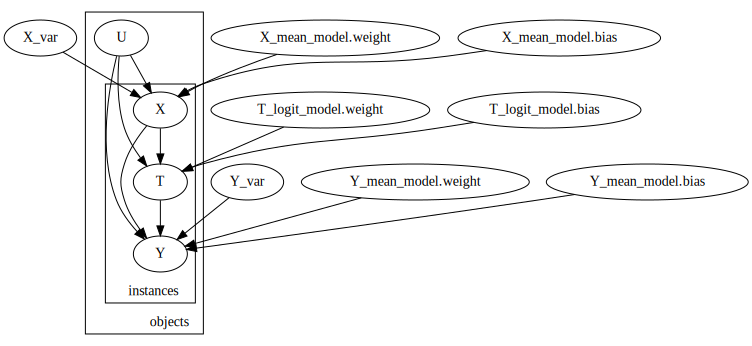

In [5]:
class BayesianLinear(pyro.nn.PyroModule):
    
    def __init__(self, n_inputs: int, n_outputs: int):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    def forward(self, *xs: torch.Tensor) -> torch.Tensor:
        if len(xs) > 1:
            batch_shape = torch.broadcast_shapes(*[x.shape[:-1] for x in xs])
            x = torch.cat([x.expand(batch_shape + x.shape[-1:]) for x in xs], dim=-1)
        else:
            x, = xs
        return torch.einsum("...i,...ji->...j", x, self.weight) + self.bias

    @PyroSample
    def weight(self):
        return dist.Normal(self.zero, self.one).expand([self.n_outputs, self.n_inputs]).to_event(2)  # TODO
    
    @PyroSample
    def bias(self):
        return dist.Normal(self.zero, self.one).expand([self.n_outputs]).to_event(1)  # TODO


class LinearSLC(pyro.nn.PyroModule):
    # Implements a linear structured latent confounder model.
    def __init__(self, d_X, n_objects, n_instances, d_U):
        super().__init__()
        self.d_X = d_X
        self.d_U = d_U
        self.n_objects = n_objects
        self.n_instances = n_instances
        
        # tiny buffers for device/dtype
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

        self.X_mean_model = BayesianLinear(self.d_U, self.d_X)
        self.T_logit_model = BayesianLinear(self.d_X + self.d_U, 1)
        self.Y_mean_model = BayesianLinear(self.d_X + self.d_U, 2)
        
    @PyroSample
    def X_var(self):
        return dist.HalfCauchy(self.one).expand([self.d_X]).to_event(1)
    
    @PyroSample
    def Y_var(self):
        return dist.HalfCauchy(self.one)
    
    def forward(self):
        # avoid these appearing in plates - kind of gross
        self.X_var, self.Y_var
        self.X_mean_model.weight, self.X_mean_model.bias
        self.T_logit_model.weight, self.T_logit_model.bias
        self.Y_mean_model.weight, self.Y_mean_model.bias
        
        # This structure implicitly assumes that each object has the same number of instances, and vice-versa. 
        # That's ok for this data, but would need to change for general SLC settings.
        with pyro.plate("objects", self.n_objects, dim=-1) as objects:
            
            # Sample object-level latent confounders, U, for each object (e.g. school)
            U = pyro.sample("U", dist.Normal(self.zero, self.one).expand([self.d_U]).to_event(1))
            
            with pyro.plate("instances", self.n_instances, dim=-2) as instances:
                
                # Sample instance-level covariates, X, treatment, T, and outcome, Y, for each instance (e.g. course)
                X_loc, X_scale_tril = self.X_mean_model(U), torch.diag_embed(self.X_var)
                X = pyro.sample("X", dist.MultivariateNormal(loc=X_loc, scale_tril=X_scale_tril))
                
                T_logit = self.T_logit_model(U, X)[..., 0]
                T = pyro.sample("T", dist.Bernoulli(logits=T_logit))
                
                Y_locs = self.Y_mean_model(U, X)
                Y_loc = torch.where(T == 0., Y_locs[..., 0], Y_locs[..., 1])
                Y = pyro.sample("Y", dist.Normal(loc=Y_loc, scale=self.Y_var))
                
                return Y


linear_slc = LinearSLC(d_X=d_X, n_objects=n_objects, n_instances=n_instances, d_U=2)
pyro.render_model(linear_slc)

### Informal Prior Predictive Check - Visualizing Samples

As this model involved several priors over multiple parameters, it is helpful to probe some implications of these modeling decisions on the induced distribution over individual attributes. As we always expect to be conditioning on covariates in our analyses, we only focus on sampling from the prior distribution on `Y` random variables conditional on the observed `X_obs` and `T_obs`.

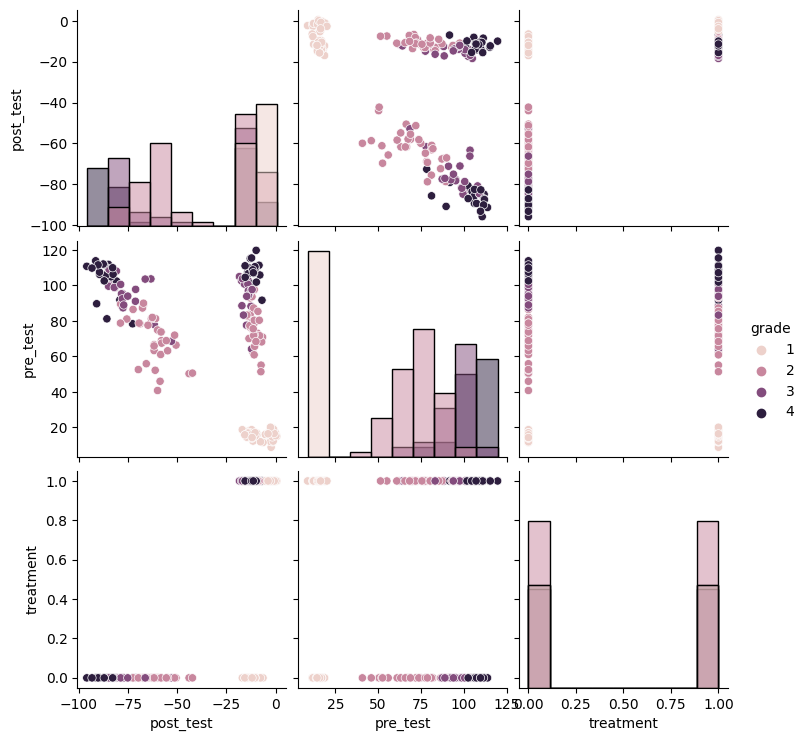

In [6]:
def plot_predictive(model, X_obs, T_obs, guide=None):

    model = condition(data=dict(X=X_obs, T=T_obs))(model)
    
    if guide:
        guide_tr = pyro.poutine.trace(guide).get_trace()
        model_tr = pyro.poutine.trace(pyro.poutine.replay(model, trace=guide_tr)).get_trace()
    else:
        model_tr = pyro.poutine.trace(model).get_trace()

    Y = model_tr.nodes['Y']['value']

    data_copy = df.copy()
    data_copy["source"] = "data"

    predictive_copy = df.copy()
    predictive_copy['post_test'] = Y.reshape(-1, 1).detach().numpy()  
    predictive_copy["source"] = "predictive"

    sns.pairplot(predictive_copy.drop("pair_id", axis=1), hue="grade", diag_kind="hist")

plot_predictive(linear_slc, X_obs, T_obs, None)

Here we can see that our prior is very uninformative. In addition, our prior ignores some knowledge we could bring to bear on the problem, e.g. that the test scores should be strictly positive. Even so, we can still yield reasonable causal estimates as we'll see later.

## Causal Query: average treatment effect (ATE)

Just as in the [backdoor](backdoor.ipynb) example, here we wish to compute the *average treatment effect*, $ATE = \mathbb{E}[Y=1|do(T=1)] - \mathbb{E}[Y=1|do(T=0)]$.

In words, in this setting the ATE tells us how much greater the students' test scores would be across all individuals if we forced everyone to be shown the "Electric Company" educational program relative to if we forced everyone to not be shown the "Electric Company" educational program. Here, we are interested in the average over the entire population.

To implement this query in ChiRho we extend our `LinearSLC` model by applying two interventions, `do(actions=dict(T=torch.zeros(treatment_shape))` and `do(actions=dict(T=torch.zeros(treatment_shape))`, and then sampling jointly from counterfactual worlds using the `MultiWorldCounterfactual` handler. Recall from the [tutorial](tutorial_i.ipynb) that the `MultiWorldCounterfactual` handler modifies the execution of the causal model to sample jointly from the observational and all counterfactual worlds induced by an intervention.

**Note:** Here we define the queried model in terms of the "individual treatment effect" (ITE), i.e. the estimated difference in outcomes for each individual under treated and control conditions. Given estimates of the ITE, we can later perform post-hoc analyses to produce estimates of post-stratified average treatment effects. Specifically, later we'll show average treatment effects conditional on the school grade.

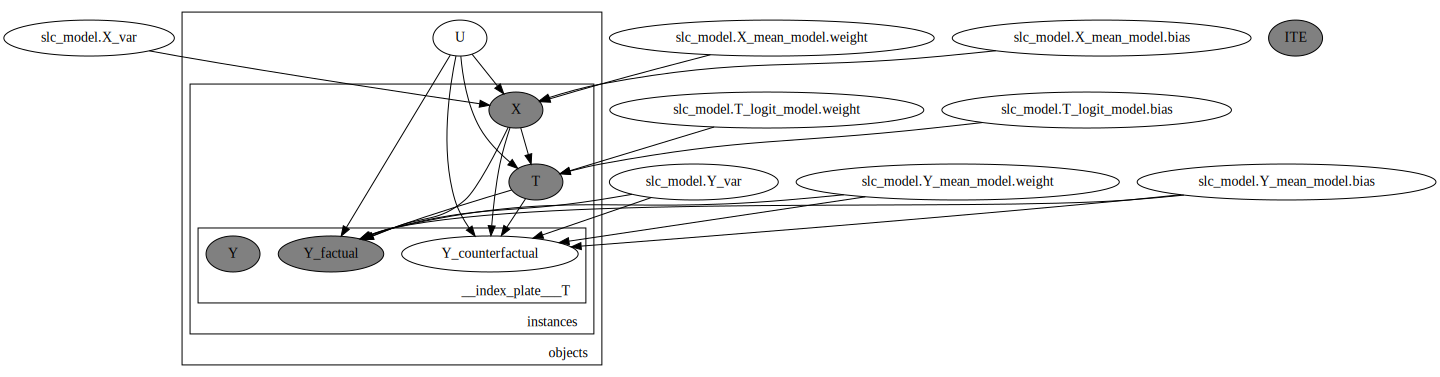

In [7]:
class LinearSLCITE(pyro.nn.PyroModule):
    def __init__(self, slc_model: LinearSLC):
        super().__init__()
        self.slc_model = slc_model

    def forward(self, X_obs, T_obs, Y_obs):
        with MultiWorldCounterfactual(), \
                condition(data=dict(X=X_obs, T=T_obs, Y=Y_obs)), \
                do(actions=dict(T=(0., 1.))):
            
            Ys = self.slc_model()
            Y_treatment = gather(Ys, IndexSet(T={2}))
            Y_control = gather(Ys, IndexSet(T={1}))
            return pyro.deterministic("ITE", (Y_treatment - Y_control)[..., None, None, :, :], event_dim=2)
        

linear_slc = LinearSLC(d_X=d_X, n_objects=n_objects, n_instances=n_instances, d_U=2)
linear_slc_ite = LinearSLCITE(linear_slc)
pyro.render_model(linear_slc_ite, model_args=(X_obs, T_obs, Y_obs))

## Causal Inference as Probabilistic Inference

In this section we show the use of multiple variants of Pyro's stochastic variational inference to solve our causal inference problem. 

### Gaussian Mean Field Variational Inference

Here we implement mean field variational inference by replacing the `AutoDelta` variational family constructor with an `AutoNormal`. In addition, we make some minor changes to the optimizer.

In [8]:
class LightningSVI(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo

    def configure_optimizers(self):
        return torch.optim.Adam(self.elbo.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        return self.elbo(*batch)


guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(hide=["Y_counterfactual"])(linear_slc_ite))
elbo = pyro.infer.Trace_ELBO(num_particles=10, vectorize_particles=True)
elbo = elbo(linear_slc_ite, guide)

# initialize parameters
elbo(X_obs, T_obs, Y_obs)

# fit parameters
train_dataset = torch.utils.data.TensorDataset(X_obs, T_obs, Y_obs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=X_obs.shape[0])
svi = LightningSVI(elbo, lr=0.03)  # 0.03
trainer = pl.Trainer(max_epochs=2000, log_every_n_steps=1)
trainer.fit(svi, train_dataloaders=train_dataloader)

/home/eli/development/pyro/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'Y_counterfactual'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/eli/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To prope

Training: 0it [00:00, ?it/s]

/home/eli/development/pyro/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'Y_counterfactual'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
`Trainer.fit` stopped: `max_epochs=2000` reached.


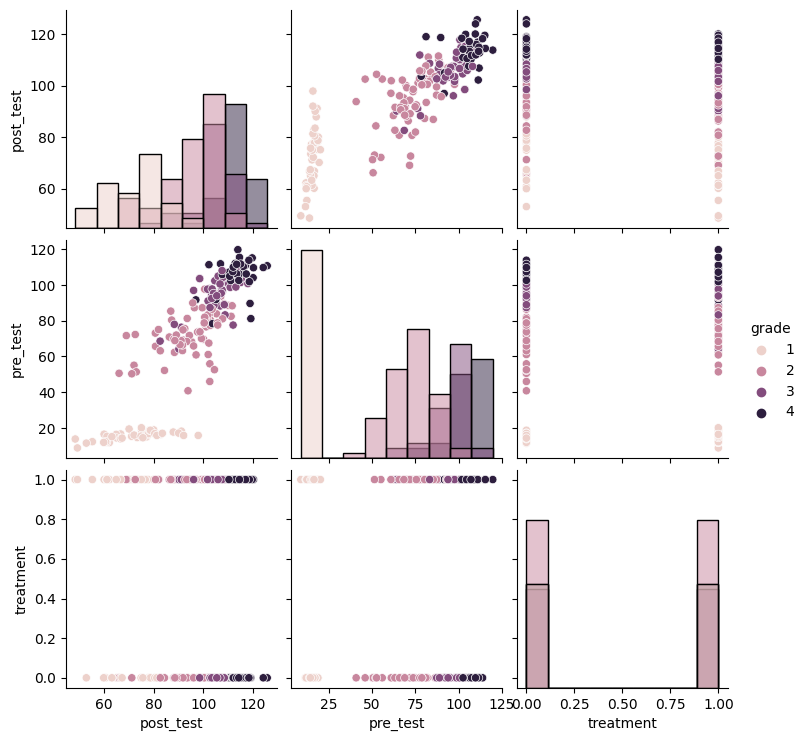

In [12]:
predictive = pyro.infer.Predictive(linear_slc_ite, guide=guide, num_samples=1000, parallel=False)
mf_prediction = predictive(X_obs, T_obs, Y_obs)["ITE"]

# Visualize posterior predictive sample
plot_predictive(linear_slc, X_obs, T_obs, guide=guide)

## Results

Here, we compare the results of our probabilsitic programming approach with a linear multi level model from Chapter 23 of Gelman and Hill's textbook "Data Analysis using Regression and Multilevel/Hierarchical Models" \[Gelman and Hill 2006\].

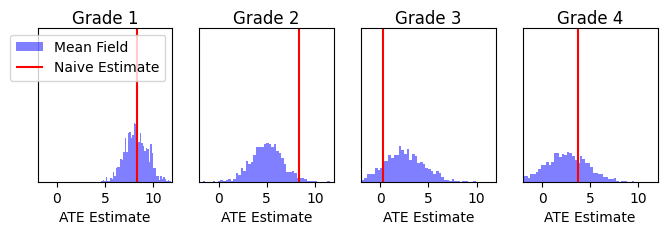

In [13]:
naive_prediction = Y_obs[1, :] - Y_obs[0, :]

naive_index = X_obs[..., 1:] == 1
mf_grade_index = X_obs[..., 1:].expand(mf_prediction.shape + (-1,)) == 1

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True)

for i in range(4):

    # Plot the Mean Field posterior predictive distribution
    ax[i].hist(mf_prediction[mf_grade_index[..., i]].reshape((mf_prediction.shape[0], -1)).mean(-1).detach().cpu().numpy(), bins=50, density=True, color="blue", alpha=0.5, label="Mean Field")

    # Plot the naive ATE distribution
    ax[i].vlines(naive_prediction[naive_index[..., 0, :, i]].mean(-1).detach().cpu().numpy(), 0, 1, color="red", label="Naive Estimate")

    ax[i].set_title("Grade {}".format(i+1), pad=-10)
    ax[i].set_yticks([])
    ax[i].set_ylim(0, 1.)
    ax[i].set_xlim(-2, 12)
    ax[i].set_xlabel("ATE Estimate")
ax[0].legend()

These results appear qualitatively very similar to the graphic on page 505 of Gelman and Hill's textbook "Data Analysis using Regression and Multilevel/Hierarchical Models", although they do not provide numeric results for comparison.

## References

Gelman, Andrew, and Jennifer Hill. Data Analysis Using Regression and Multilevel/Hierarchical Models. Cambridge University Press, 2006. http://ecologia.ib.usp.br/curso_r/lib/exe/fetch.php/bie5782:00_curso_avancado:uriarte:gelman_hill2007_data_analysis_using_regression_and_multilevel-hierarchical_models.pdf

Shadish, William, Thomas Cook, Donald Thomas Campbell, and others. Experimental and Quasi-Experimental Designs for Generalized Causal Inference/William R. Shedish, Thomas D. Cook, Donald T. Campbell. Boston: Houghton Mifflin, 2002.

Loftus, Geoffrey, and Michael Masson. “Using Confidence Intervals in Within-Subject Designs.” Psychonomic Bulletin & Review 1, no. 4 (1994): 476–90.

Witty, Sam, David Jensen, and Vikash Mansinghka. “A Simulation-Based Test of Identifiability for Bayesian Causal Inference.” ArXiv, February 23, 2021. https://arxiv.org/abs/2102.11761.

Ball, Samuel. "Reading with Television: An Evaluation of The Electric Company. A Report to the Children's Television Workshop. Volumes 1 and 2." (1973).

Witty, Sam, Kenta Takatsu, David Jensen, and Vikash Mansinghka. “Causal Inference Using Gaussian Processes with Structured Latent Confounders.” In International Conference on Machine Learning, 10313–23. PMLR, 2020.
